In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
plt.ion()

import sklearn.svm
import sklearn.tree

## We provide you 3 datasets to play with :
- MNIST in small resolution (8x8 pixels images)
- MNIST, classic: 28x28 resolution 
- Fashion_MNIST, 28x28 resolution

In [2]:
## data set 1 ##
K=10
import sklearn.datasets
X,y = sklearn.datasets.load_digits(n_class=K, return_X_y=True)
linearPictureLength = 8 # Global variable
ratio_train = 0.6 # we may reduce this number when using mnist70 (70 000 images !)
ratio_valid = 0.3 # same here

In [3]:
## data set 2 ##
LoadObject = np.load("mnist70.npz")
linearPictureLength = 28
X = LoadObject['X']
y = LoadObject['y']
del LoadObject
ratio_train = 0.005
ratio_valid = 0.1
print(X.shape)

(70000, 784)


In [4]:
## data set 3 ##
LoadObject = np.load("fashion-mnist-reshaped.npz")
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']
X     = np.array(X    , dtype=float) ## change the type, which is iniitially unsigned-int (uint)
Xtest = np.array(Xtest, dtype=float)
del LoadObject
ratio_train = 0.05
ratio_valid = 0.1
print(X.shape)

(60000, 784)


## We load the data and split it into train, validation and test set.

It's good to do this early, and remember to only use the train set for most operations.

The validation set may be used to find the best hyper-parameters

The test can be used.. only **once** ! Then it "expires", like old food is wasted after a couple of weeks.

In [5]:
def load_subSets(X, ratio_train, ratio_valid):
    ratio_test = 1 - ratio_train - ratio_valid #
    assert(ratio_test>0)
    Ntot   = X.shape[0]
    Ntrain = int(ratio_train*Ntot)
    Nvalid = int(ratio_valid*Ntot)
    Ntest  = Ntot - Ntrain - Nvalid
    X_train = X[0: Ntrain].copy()
    y_train = y[0: Ntrain].copy()
    X_valid = X[Ntrain:Ntrain+Nvalid].copy() #  X[-Ntest:] also does the same
    y_valid = y[Ntrain:Ntrain+Nvalid].copy() # 
    X_test  = X[-Ntest:].copy()
    y_test  = y[-Ntest:].copy()
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [6]:
## actually load the data into separate arrays
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)
X_train.shape

(3000, 784)

# First part: getting a sense of what PCA does

## 1.1 Normalization

- take a quick look at the data: what does it look like ? What are the min and max values ?
- normalize the input so all values of the training set are between 0 and 1. Perform the appropriate operation on the val and test sets so that they are consistent with this pre-processing operation.

9


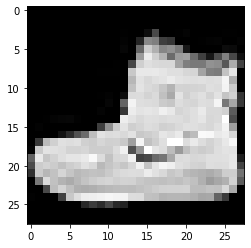

In [7]:
n=0
plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
print(y[n])

In [8]:
# print(X.shape, X[n], y[n])

## Normalization: here we choose to simply perform min-max normalization

What are the other choices ?

Other common pre-processing choices are:
- standardization (subtract the mean, divide by the standard deviation)
- simple centering (subtract only the mean)
- PCA (!)

In [9]:
# we set X (the gray levels) between 0 and 1
max_level = X_train.max()*1.0
X_train /= max_level
X_valid /= max_level
X_test  /= max_level

# Remark !

We divide each sub-part of the data by the **same** value, not each by its max !

This is important: in the spirit of pre-processing and train/val/test split, you must use only the training data to pre-process (all) the data, including the validation and test sets.

The pipeline is not supposed to know in advance hte maximum value of the validation or test sets !


## 1.2 Your first PCA compression (+decompression)


We want to see what typical PCA does on an image.
- using the method `sklearn.decomposition.PCA` from the `scikit-learn` library, compress the training set (i.e. perform its PCA). Then, decompress this compressed version, and compare an image before and after its transformation.  For this, you will need to :
    - define an instance of the class `sklearn.decomposition.PCA`, that we may call "model" or "preProcessing"
    - use the methods `fit`, `transofrm` and `inverse_transform`
    - use the plot funciton  `plot_before_vs_after_compression` that we provide below
    - remember to make copies, not in-place transformation !
    - to start, you can use an explained variance ratio of 95%
- compare a couple of images (pick random images, just to take a look not just at 1 case)
- compute the Squared Error (squared difference between original and compresse+decompressed images) for a single image.
- compute the Mean Squared Error (same thing but averaged on all training set images).
- by browsing the methods of `sklearn.decomposition.PCA`, find a way to display the *explained variance ratio*, for all possible values of the number of PCA components to be kept. Plot it on a graph.
- display the before/after image comparison for a low number of components, e.g. 30

In [10]:
def plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y):
    plt.figure()
    plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " before compression")
    plt.savefig(str(n)+"_beforeCompression.png")

    plt.figure()
    plt.imshow(X_train_Transf_decompressed[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " after compression+decompression")
    plt.savefig(str(n)+"_afterCompression.png")

    print("The MSE for this image is ", np.mean( (X_train[n]- X_train_Transf_decompressed[n])**2) )

The MSE for this image is  145.40920372231986
MSE totale (Mean Squared Error) 282.8568741356472


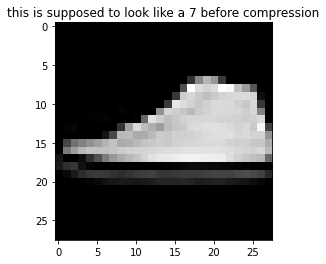

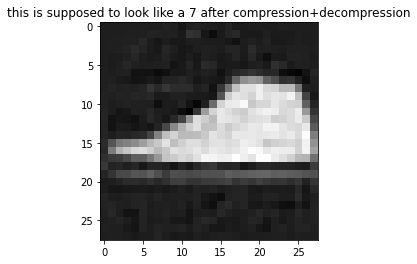

In [11]:
### 1st attempt at PCA with an explained_variance ratio set to 0.95

X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)

varianceExplained=0.95
preProc = sklearn.decomposition.PCA(n_components=varianceExplained, copy=True)
preProc.fit(X_train)

X_train_Transformed = preProc.transform(X_train)
X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)

n=41 # image number 42 (41+1)
plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y)

diff = X_train_Transf_decompressed - X_train
totalMeanSquaredError = np.mean(diff**2)
print("MSE totale (Mean Squared Error)", totalMeanSquaredError)

(0.0, 1.0)

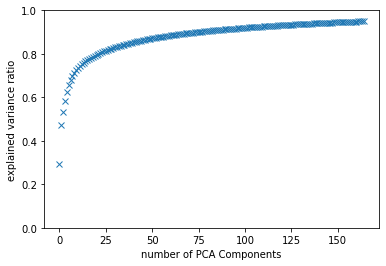

In [12]:
## displaying the total variance explained at various values of nComp
CumulativeExplainedVariance = np.cumsum(preProc.explained_variance_ratio_)
plt.plot(CumulativeExplainedVariance, ls= "", marker='x')
plt.xlabel("number of PCA Components")
plt.ylabel("explained variance ratio")
plt.ylim([0,1])

The MSE for this image is  52.63949442092677


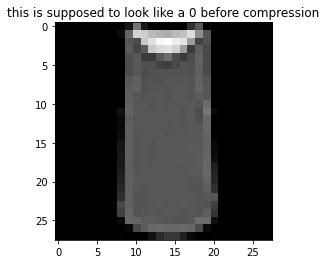

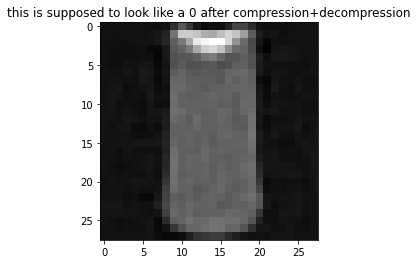

In [13]:
plot_before_vs_after_compression(2, X_train, X_train_Transf_decompressed, y)

The MSE for this image is  945.5059095825783


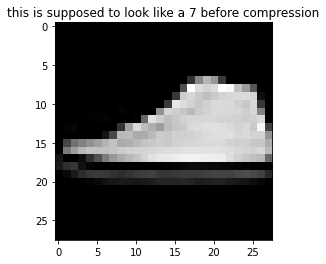

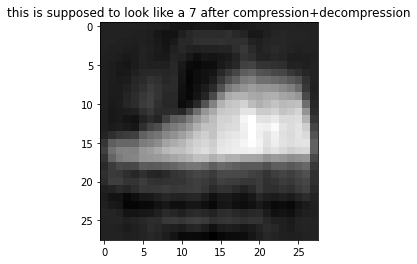

In [14]:
# varianceExplained=30 # 30 compnents
preProc = sklearn.decomposition.PCA(n_components=30, copy=True)
preProc.fit(X_train)
X_train_Transformed = preProc.transform(X_train)
X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)

n=41 # image number 42 (41+1)
plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y)


## Comments:

- The explained variance monotonously increases with the number of components, as expected.
- even with few components, the compression is not so bad !

# Second part: make your own PCA !

Now we want to really make sure we understand how PCA is, or can be done.

## 2.1 Theory

- Check out the lecture notes and make sure you understood the maths


## 2.2 PCA 

Compute the PCA of the training set, using:
- `np.mean(..., axis=...)` to compute the average of an array along one of its axes
- `np.outer` computes the outer product of two vectors (you can also cheat and use `np.cov`... but it's cheating)
- `.tranpose()` (applied on an array, or `np.transpose()` if you will). A shortcut for `a.transpose()` is `a.T`
- `np.linalg.eig`, which computes the full system of eigenvalues and eigenvectors (with nornmalized eigenvectors)
- `np.dot`, which compute the dot product (or matrix product). You can also use `np.matmul` if you have matrices.
- `np.linalg.inv`, which computes the inverse of a matrix (and does not raise any warning when it is not invertibe, sadly)

#### We check some identities to make sure we understand how `np.linal.eig` works

In [15]:
np.random.seed(42)
a = np.random.random((3,3))
w, v = np.linalg.eig(a)
for i in range(a.shape[0]):
    print(np.dot(a[:,:], v[:,i]) - w[i] * v[:,i])

[ 4.44089210e-16 -6.66133815e-16  2.22044605e-16]
[-1.38777878e-17 -1.24900090e-16  2.49800181e-16]
[ 1.99493200e-16  1.17961196e-16 -6.93889390e-17]


In [16]:
np.dot(a, v) - np.dot(v, np.diag(w))

array([[ 4.44089210e-16, -4.85722573e-17,  2.41126563e-16],
       [-7.77156117e-16, -1.24900090e-16,  1.11022302e-16],
       [ 2.22044605e-16,  2.77555756e-16, -9.71445147e-17]])

In [17]:
# np.sum(np.abs(np.linalg.inv(v) - v.transpose() ))
# ## eigenvectors are orthonrmal, i.e. their transpose and inverse is the same thing !
# ## the tranpose is cost-less, compared to the inverse (very costly)

In [18]:
np.dot(np.linalg.inv(v), np.dot(a, v)) - np.diag(w)

array([[ 0.00000000e+00, -2.03595284e-17, -1.52004884e-16],
       [-3.71767387e-15,  6.66133815e-16, -1.06798350e-15],
       [-4.00459437e-15,  9.70930783e-16, -1.20736754e-15]])

In [19]:
## we subtract the mean, once and for all 
mean_X_train = X_train.mean(axis=0)
X_centered = X_train - mean_X_train  
## remember to also do it for the validaiton and test set, in a real case !

In [20]:
## we compute the covariance matrix
N = X_centered.shape[0]
D = X_centered.shape[1]
C = np.zeros((D,D)) ## the covariance matrix
for n in range(N):
    C += np.outer(X_centered[n],X_centered[n])
C /= (N-1)

In [21]:
# ## we can also cheat, with this: 
# cc = np.cov(X_centered.transpose())
# abs(cc*(N-1) -  C).sum()
# C = cc

In [22]:
## this is the computationally-intensive part, that we perform using the linear algebra library !
w, v = np.linalg.eig(C)

In [23]:
## perform a quick check that the diagonalization went smoothly
np.sum(np.abs(np.dot(np.linalg.inv(v), np.dot(C, v)) - np.diag(w) ))

1.9813560915076e-06

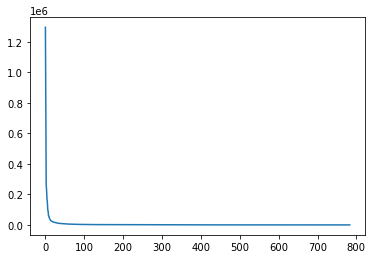

In [24]:
## we check whether eigenvlues are sorted, and in the same time we take a look at their values
plt.plot(w)

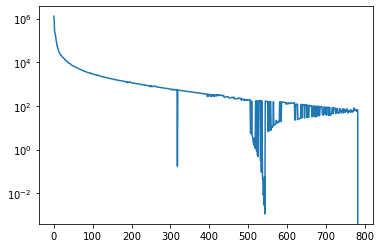

In [25]:
# log plot (in y axis) seems more appropriate
plt.semilogy(w)

In [26]:
# we choose a number of components
nComp = 30

In [27]:
# we keep only the first nComp eigenvectors (this is the compression part)
P = (np.linalg.inv(v)[:nComp])
P.shape

(30, 784)

In [28]:
## we transform the whole dataset at once
X_transformed = np.dot(P, X_centered.T)
## we should do the same for vlaidation and test sets here.
X_transformed.shape

(30, 3000)

## 2.3 Transform the compressed dataset back to the original space

- Remember that the "decompression" is done by $X_{back} = P^T . X'$

In [29]:
Xback_transformed = np.dot(P.T, X_transformed).T # equivalent of X_train_Transf_decompressed , but made by hand
Xback_transformed += mean_X_train
Xback_transformed.shape

(3000, 784)

## 2.4  compare with/without compression+decompression

The MSE for this image is  947.5233547639845


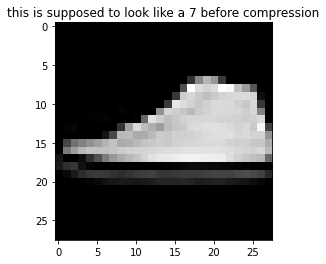

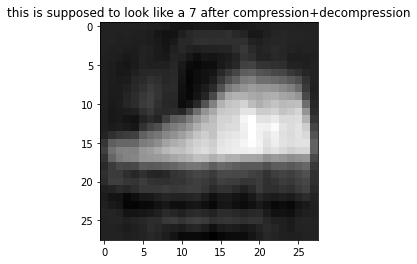

In [30]:
n=41
plot_before_vs_after_compression(n, X_train, Xback_transformed, y)

### We even compare our compression and the one performed by sklearn, to check again:

The MSE for this image is  0.06888043023669066


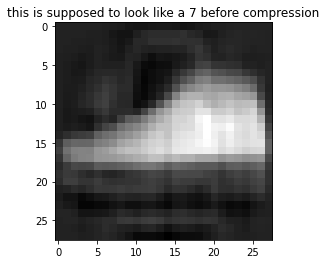

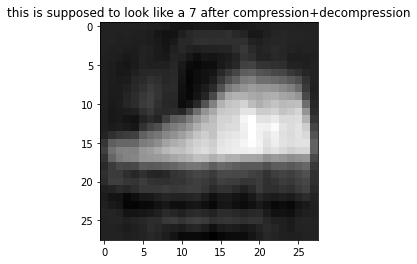

In [31]:
plot_before_vs_after_compression(n, X_train_Transf_decompressed, Xback_transformed, y)

In [32]:
(X_train_Transf_decompressed[n] -  Xback_transformed[n])/X_train_Transf_decompressed[n] 

array([ 1.00000000e+00, -4.74135059e-02, -2.77561884e-02,  1.26972590e-03,
        5.97094920e-04, -3.88064332e-03, -2.77419152e-03, -1.45545078e-02,
       -2.08245315e-02, -7.38433394e-03,  4.67317253e-03,  2.64920289e-02,
        5.58060007e-02,  5.69953140e-02,  5.78168516e-02,  5.52528348e-02,
        4.19492352e-02,  2.07548271e-02,  6.45656050e-03,  4.10846948e-03,
        7.38786397e-03,  4.18273916e-02, -1.38591500e+00, -1.05479734e-02,
       -3.45363565e-02, -3.65104397e-02, -3.70102707e-02, -4.22425861e-02,
       -1.99018818e-03,  6.43531898e-03, -1.77209359e-02,  7.19852336e-03,
        8.01253614e-03, -1.03293236e-02, -3.02421411e-02, -2.16003179e-02,
       -1.62221727e-02, -1.41404442e-02, -1.20602250e-01,  5.63272698e-02,
        2.05340414e-02,  2.05230518e-03,  4.20010874e-03, -1.37120843e-03,
       -2.01000113e-03,  1.33654693e-02,  7.26340726e-02, -4.33192748e-03,
        3.00966625e-03,  1.43304931e-02, -5.86917101e-02, -3.36083183e-02,
       -5.68409636e-02, -

## Third part: optimizing the number of components

For this part, we consider the PCA not as an end in itself, but as a pre-processing tool.

The idea is that if we have an over-parameterized model because the input dimension is too large, what we can do is compress it, and use the compressed "image" (which does not look like an image, since it has `nComp` dimensions..) as input. 

When `nComp` is too small, we will loose so much information about the input that the results will be worse. If `nComp` is too large, we do not compress much and so the model remains over-parameterized.

**The goal of this part is to optimize the hyper-parameter `nComp` so as to get the best possible results.**

For this, we are going to use an algorithm that we haven't yet seen in class: SVMs (*Support Vector Machines*), with a Polynomial *Kernel*, say of degree 3. We will see what this means in lecture 3.
For now you can think of this as a black-box classification algorithms that simply "does pretty good".

You are provided with these lines of code:

`clf = sklearn.svm.SVC(C=0.01, kernel='poly', degree = 3, coef0 = 1)
clf.fit(X_train_Transformed, y_train)`

which define a SVM classfier with polynomial Kernel of degree 3 (and C is intentionally set a bit too low here).

Here it is also advised to use the third data set (otherwise it's not very interesting), with not too much training data.


In [7]:
## data set 3 ##
LoadObject = np.load("fashion-mnist-reshaped.npz")
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']
X     = np.array(X    , dtype=float) ## change the type, which is iniitially unsigned-int (uint)
Xtest = np.array(Xtest, dtype=float)
del LoadObject
ratio_train = 0.05
ratio_valid = 0.1
print(X.shape, X_train.shape)

(60000, 784) (3000, 784)


In [8]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)

### Hint: 

You should use the function `clf.score` to compute the training score and validation score.


In [9]:
clf = sklearn.svm.SVC(C=0.01, kernel='poly', degree = 3, coef0 = 1)
clf.fit(X_train, y_train)
trainscore = clf.score(X_train,y_train)
validscore = clf.score(X_valid,y_valid)
## TODO: compute scores here
print("no compression:    training score:",trainscore, ". valid score:", validscore)

no compression:    training score: 0.7493333333333333 . valid score: 0.7236666666666667


In [16]:
linear_training_score = []
linear_valid_score = []

# nComp_range = [1,2,3,6,10,20,30,40,50,64]
nComp_range = np.arange(1,102,10)
for nC in nComp_range:
    
    ## pre-processing 
    preProc = sklearn.decomposition.PCA(n_components=nC, copy=True)
    preProc.fit(X_train)
    X_train_Transformed = preProc.transform(X_train)
    X_valid_Transformed = preProc.transform(X_valid) ## applt the SAME transform to the validation data

    ## classification
    clf = sklearn.svm.SVC(C=10, kernel='poly', degree = 2, coef0 = 1)
    clf.fit(X_train_Transformed, y_train)
    
    ## measure of performance
    trainscore = clf.score(X_train_Transformed,y_train)
    validscore = clf.score(X_valid_Transformed,y_valid)
    print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
    
    ## recordings
    linear_training_score.append(trainscore)
    linear_valid_score.append(validscore)

nombre Composants 1    training score: 0.3233333333333333 . valid score: 0.30733333333333335
nombre Composants 11    training score: 0.8616666666666667 . valid score: 0.8058333333333333
nombre Composants 21    training score: 0.9056666666666666 . valid score: 0.8296666666666667
nombre Composants 31    training score: 0.931 . valid score: 0.836
nombre Composants 41    training score: 0.9456666666666667 . valid score: 0.8386666666666667
nombre Composants 51    training score: 0.9563333333333334 . valid score: 0.8401666666666666
nombre Composants 61    training score: 0.9616666666666667 . valid score: 0.839
nombre Composants 71    training score: 0.9656666666666667 . valid score: 0.842
nombre Composants 81    training score: 0.9713333333333334 . valid score: 0.839
nombre Composants 91    training score: 0.976 . valid score: 0.8411666666666666
nombre Composants 101    training score: 0.977 . valid score: 0.8443333333333334


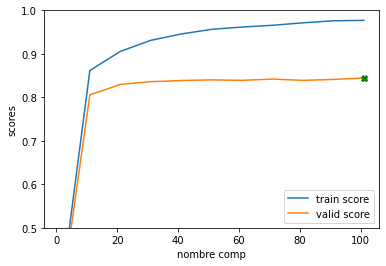

In [17]:
## plot of scores vs the hyper-param nc (nothing to do here)
plt.figure()
plt.plot(nComp_range[:30], linear_training_score[:30], label= "train score")
plt.plot(nComp_range[:30], linear_valid_score[:30], label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])

## outlining where the best point is (validation set)
## here we make a crude choice, which can be refine dby hand, of course
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')

## I do it again, for an other (better) example

In [14]:
X_train.shape

(3000, 784)

In [15]:
linear_training_score = []
linear_valid_score = []

# nComp_range = [1,2,3,6,10,20,30,40,50,64]
nComp_range = np.arange(2,784,50)
for nC in nComp_range:
    
    ## pre-processing 
    preProc = sklearn.decomposition.PCA(n_components=nC, copy=True)
    preProc.fit(X_train)
    X_train_Transformed = preProc.transform(X_train)
    X_valid_Transformed = preProc.transform(X_valid) ## applt the SAME transform to the validation data

    ## classification
    clf = sklearn.svm.SVC(C=10, kernel='rbf', degree = 3, coef0 = 1)
    clf.fit(X_train_Transformed, y_train)
    
    ## measure of performance
    trainscore = clf.score(X_train_Transformed,y_train)
    validscore = clf.score(X_valid_Transformed,y_valid)
    print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
    
    ## recordings
    linear_training_score.append(trainscore)
    linear_valid_score.append(validscore)

nombre Composants 2    training score: 0.5553333333333333 . valid score: 0.5525
nombre Composants 52    training score: 0.9716666666666667 . valid score: 0.8478333333333333
nombre Composants 102    training score: 0.9856666666666667 . valid score: 0.8521666666666666
nombre Composants 152    training score: 0.9903333333333333 . valid score: 0.852
nombre Composants 202    training score: 0.9933333333333333 . valid score: 0.854
nombre Composants 252    training score: 0.994 . valid score: 0.8546666666666667
nombre Composants 302    training score: 0.995 . valid score: 0.853
nombre Composants 352    training score: 0.9953333333333333 . valid score: 0.8535
nombre Composants 402    training score: 0.9956666666666667 . valid score: 0.853
nombre Composants 452    training score: 0.996 . valid score: 0.8528333333333333
nombre Composants 502    training score: 0.9966666666666667 . valid score: 0.8533333333333334


KeyboardInterrupt: 

In [ ]:
## plot of scores vs the hyper-param nc (nothing to do here)
plt.figure()
plt.plot(nComp_range[:30], linear_training_score[:30], label= "train score")
plt.plot(nComp_range[:30], linear_valid_score[:30], label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])

## outlining where the best point is (validation set)
## here we make a crude choice, which can be refine dby hand, of course
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')

## 3.2 Compute the test error

In [39]:
###############
### test:  ####

X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)

nC = bestNC
preProc = sklearn.decomposition.PCA(n_components=nC, copy=True)
preProc.fit(X_train)
X_train_Transformed = preProc.transform(X_train)
X_valid_Transformed = preProc.transform(X_valid)
X_test_Transformed  = preProc.transform(X_test)

clf = sklearn.svm.SVC(C=0.01, kernel='poly', degree = 3, coef0 = 1)
clf.fit(X_train_Transformed, y_train)
trainscore = clf.score(X_train_Transformed,y_train)
validscore = clf.score(X_valid_Transformed,y_valid)
testscore  = clf.score(X_test_Transformed,y_test)

print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
print("test score: ", testscore)

nombre Composants 51    training score: 0.7603333333333333 . valid score: 0.7366666666666667
test score:  0.7427843137254901


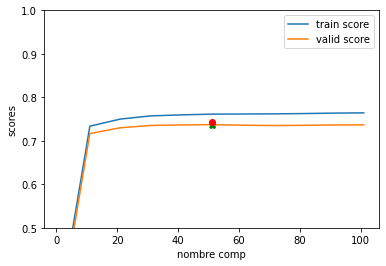

In [40]:
## plot of scores vs the hyper-param nc (nothing to do here)
plt.figure()
plt.plot(nComp_range[:30], linear_training_score[:30], label= "train score")
plt.plot(nComp_range[:30], linear_valid_score[:30], label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])

## outlining where the best point is (validation set)
## here we make a crude choice, which can be refine dby hand, of course
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')
plt.plot(bestNC, testscore, marker='o', color='red')